In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns

In [15]:
# Path to the water segmentation dataset folder
data_dir = r"C:\Users\dockn\riwa_v2"
images_dir = os.path.join(data_dir, r"images")
masks_dir = os.path.join(data_dir, r"masks")

train_data = []
for img, msk in zip(os.listdir(images_dir), os.listdir(masks_dir)):
   train_data.append({
       "image": os.path.join(images_dir, img),
       "annotation": os.path.join(masks_dir, msk)
   })

val_imgs = r"C:\Users\dockn\riwa_v2\validation\images"
val_msks = r"C:\Users\dockn\riwa_v2\validation\masks"
val_data = []
for img, msk in zip(os.listdir(val_imgs), os.listdir(val_msks)):
   val_data.append({
      "image": os.path.join(val_imgs, img),
      "annotation": os.path.join(val_msks, msk)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_dir = r"C:\Users\dockn\riwa_v2\test"
t_img = os.path.join(test_dir, "images")
t_msk = os.path.join(test_dir, "masks")

test_data = []
for img, msk in zip(os.listdir(t_img), os.listdir(t_msk)):
   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(t_img, img),
       "annotation": os.path.join(t_msk, msk)
   })


In [16]:
def read_batch(data, index, visualize_data=False):
    ent = data[index % len(data)]

    Img = cv2.imread(ent["image"])[..., ::-1]
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)

    inds = np.unique(ann_map)[1:]
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8) 
        binary_mask = np.maximum(binary_mask, mask)

    if visualize_data:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)
    binary_mask = binary_mask.transpose((2, 0, 1))

    return Img, binary_mask


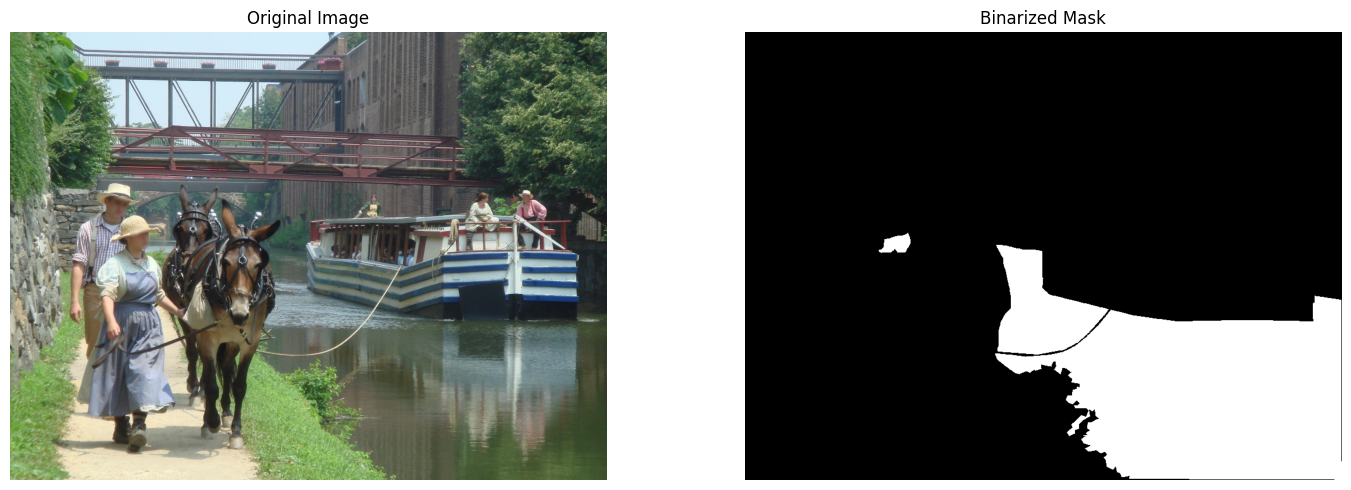

In [17]:
Img, masks = read_batch(train_data, 2, visualize_data=True)

In [38]:
masks.shape

(1, 768, 1024)

In [32]:
np.repeat(masks.squeeze()[:, :, np.newaxis], 3, axis=2).shape

(768, 1024, 3)

## Plot Coverage of Ground Truth Mask per Image

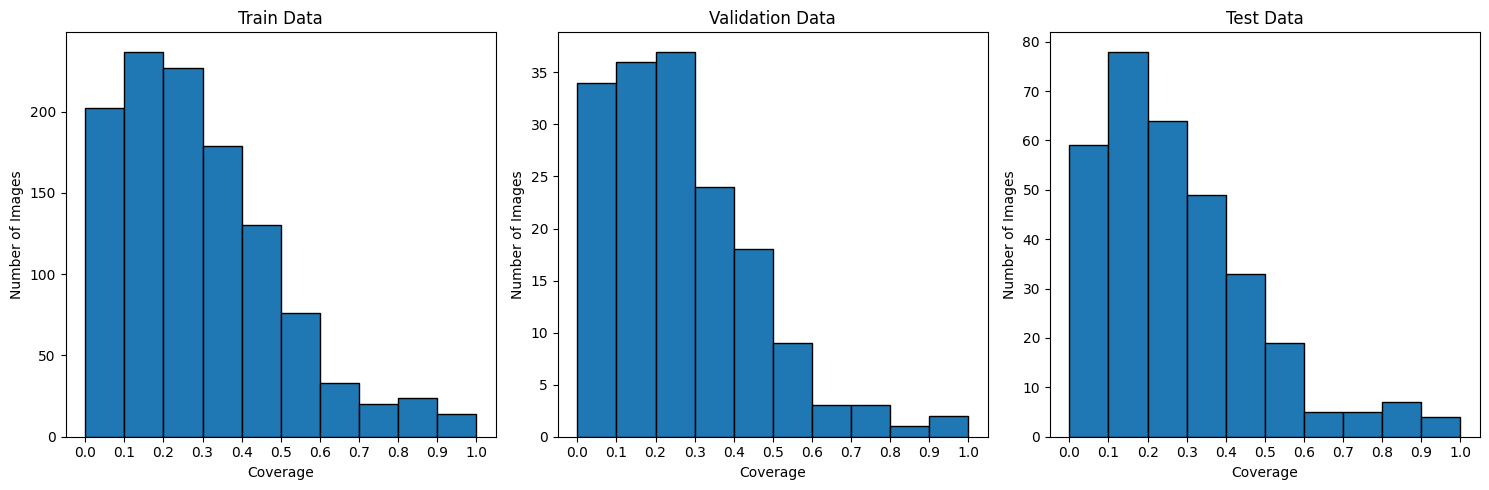

In [18]:
datasets = [(train_data, "Train Data"), (val_data, "Validation Data"), (test_data, "Test Data")]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (dataset, dataset_name) in enumerate(datasets):    
    pixel_ratio = []
    for idx, datum in enumerate(dataset):
        img, msk = read_batch(dataset, idx)
        pixel_ratio.append(msk.sum(1).sum(1) / len(img[:,:,0].reshape(-1))) # ignore RGB channel

    bins = np.arange(0, 1.1, 0.1)
    counts, edges = np.histogram(pixel_ratio, bins=bins)

    axes[i].bar(edges[:-1], counts, width=0.1, align="edge", edgecolor="black")
    axes[i].set_xlabel("Coverage")
    axes[i].set_ylabel("Number of Images")
    axes[i].set_title(dataset_name)
    axes[i].set_xticks(bins)

plt.tight_layout()
plt.show()

In [19]:
plt.close()

In [39]:
rgb_data = {}

for dataset, dataset_name in datasets:
    all_mean_pixels = []
    
    for idx in range(len(dataset)):
        img, msk = read_batch(dataset, idx)

        mask_class = msk[0] == 1

        # 마스크와 겹치는 img 픽셀 값 추출
        mean_rgb = img[mask_class].mean(axis=0)

        all_mean_pixels.append(mean_rgb)

    # 각 데이터셋에 대해 수집한 마스크 영역의 픽셀 값을 딕셔너리에 저장
    rgb_data[dataset_name] = all_mean_pixels

In [51]:
for key in rgb_data.keys():
    rgb_data[key] = np.array(rgb_data[key])

In [57]:
df1 = pd.DataFrame(rgb_data["Train Data"], columns=['Red', 'Green', 'Blue'])
df2 = pd.DataFrame(rgb_data["Validation Data"], columns=['Red', 'Green', 'Blue'])
df3 = pd.DataFrame(rgb_data["Test Data"], columns=['Red', 'Green', 'Blue'])

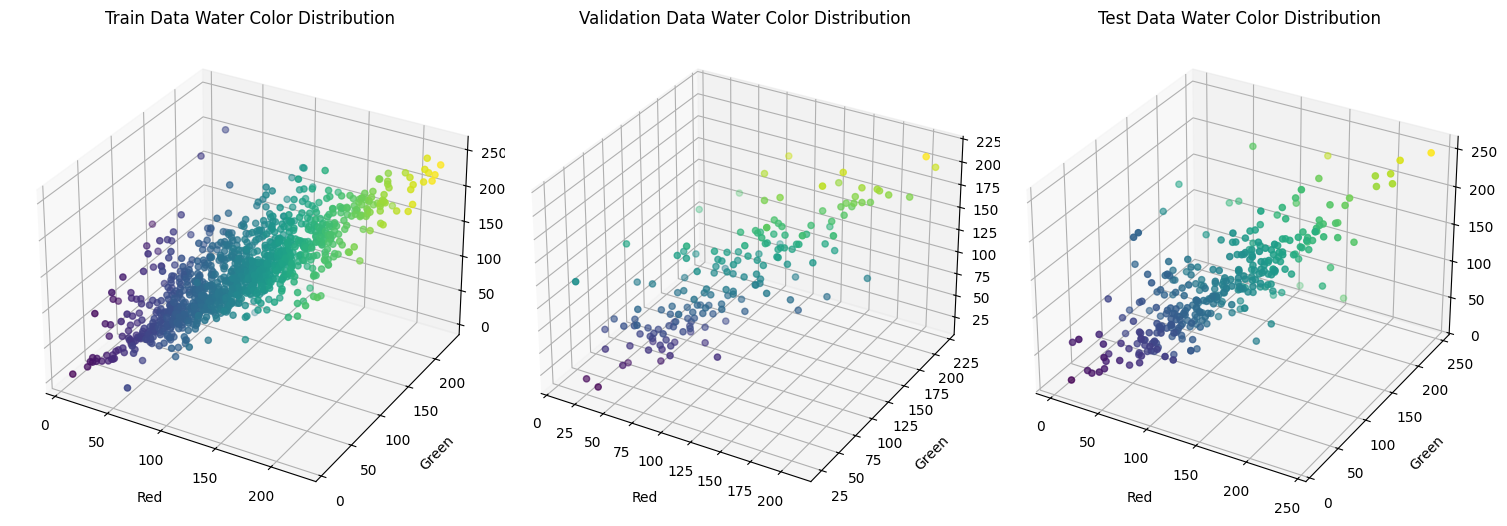

In [ ]:
# 3D scatter plot
fig = plt.figure(figsize=(15, 12))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(df1['Red'], df1['Green'], df1['Blue'], c=df1['Red'], label='Train Data')
ax1.set_xlabel('Red', labelpad=10)
ax1.set_ylabel('Green', labelpad=10)
ax1.set_zlabel('Blue', labelpad=10)
ax1.set_title('Train Data Water Color Distribution')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(df2['Red'], df2['Green'], df2['Blue'], c=df2['Blue'], label='Validation Data')
ax2.set_xlabel('Red', labelpad=10)
ax2.set_ylabel('Green', labelpad=10)
ax2.set_zlabel('Blue', labelpad=10)
ax2.set_title('Validation Data Water Color Distribution')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(df3['Red'], df3['Green'], df3['Blue'], c=df3['Green'], label='Test Data')
ax3.set_xlabel('Red', labelpad=10)
ax3.set_ylabel('Green', labelpad=10)
ax3.set_zlabel('Blue', labelpad=10)
ax3.set_title('Test Data Water Color Distribution')

plt.tight_layout()
plt.show()


In [73]:
df_total = pd.concat([df1, df2, df3], ignore_index=True)

In [74]:
df_total.corr()

,Red,Green,Blue
Red,1.000000,0.909745,0.718835
Green,0.909745,1.000000,0.903858
Blue,0.718835,0.903858,1.000000


In [ ]:
for idx, dataset in enumerate([df_total, df1, df2, df3]):
    print(f"data {idx}\n")

    for column in dataset.keys():
        print(column, f"\nmean: {dataset[column].mean()} \nstd: {dataset[column].std()}\n")

    print()

data 0

Red 
mean: 103.90623656020165 
std: 39.78178766180994

Green 
mean: 112.64019765086701 
std: 39.50154537967034

Blue 
mean: 112.75551234577338 
std: 43.85410771450008


data 1

Red 
mean: 104.35114307662676 
std: 38.992080791215926

Green 
mean: 113.668250920716 
std: 38.74837887537275

Blue 
mean: 114.41550072445355 
std: 43.21273437458835


data 2

Red 
mean: 101.73417564848658 
std: 40.90348855495345

Green 
mean: 109.58633649413413 
std: 40.06654638843824

Blue 
mean: 109.90102819734763 
std: 43.6631613875873


data 3

Red 
mean: 103.45623944100325 
std: 41.986239600316175

Green 
mean: 110.5843400007333 
std: 41.74803667187653

Blue 
mean: 108.36229910841847 
std: 45.915795071562485




In [82]:
df_total.keys()

Index(['Red', 'Green', 'Blue'], dtype='object')

C:\Users\dockn\AppData\Local\Temp\ipykernel_25936\1707317807.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


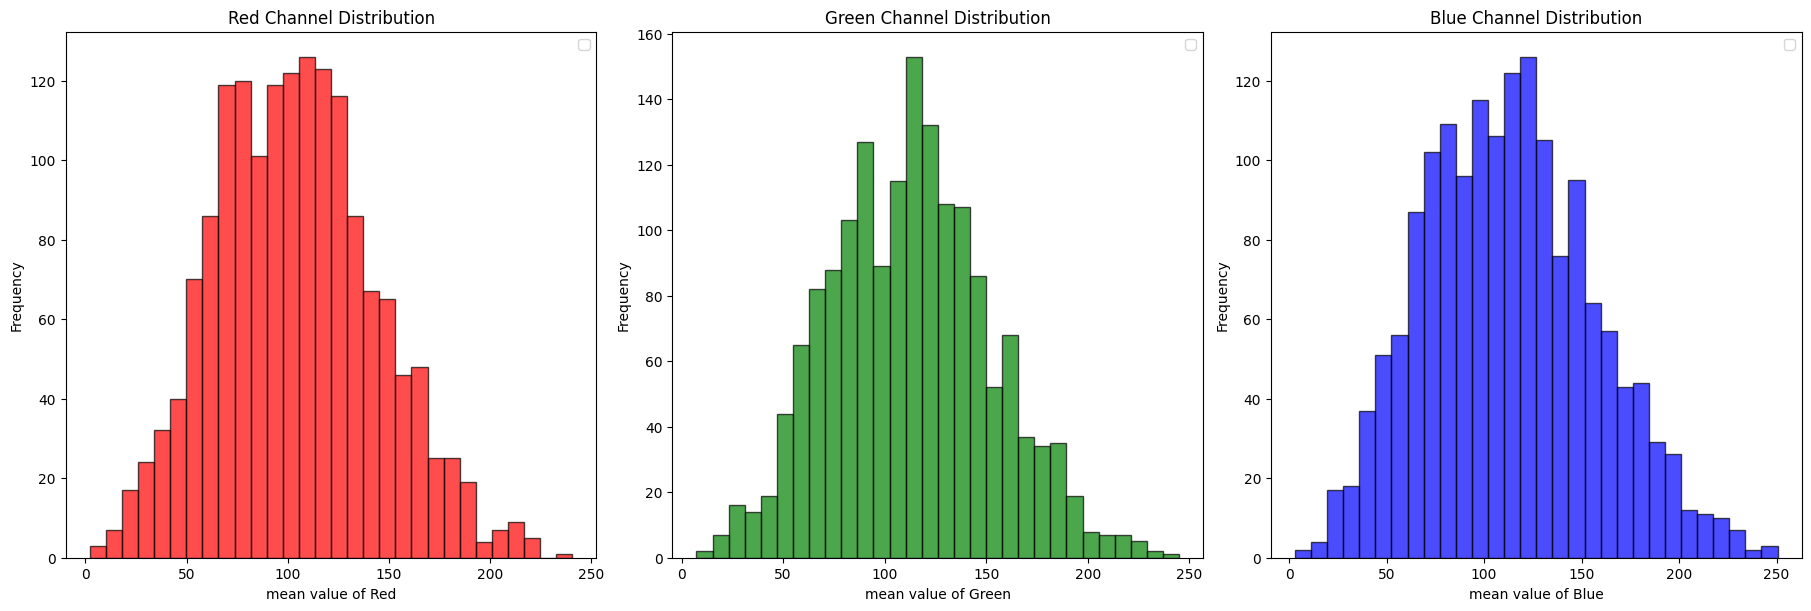

In [103]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# 각 열의 히스토그램 그리기
for i, (color, column) in enumerate(zip(["r", "g", "b"], df_total.columns)):
    ax = axes[i]
    
    ax.hist(df_total[column], bins=30, color=color, edgecolor='black', alpha=0.7)
        
    # 평균과 표준편차 계산
    mean_val = df_total[column].mean()
    std_val = df_total[column].std()
    
    # 그래프 제목과 레이블 추가
    ax.set_title(f'{column} Channel Distribution')
    ax.set_xlabel(f"mean value of {column}")
    ax.set_ylabel('Frequency')
    ax.legend()


1142
167
323


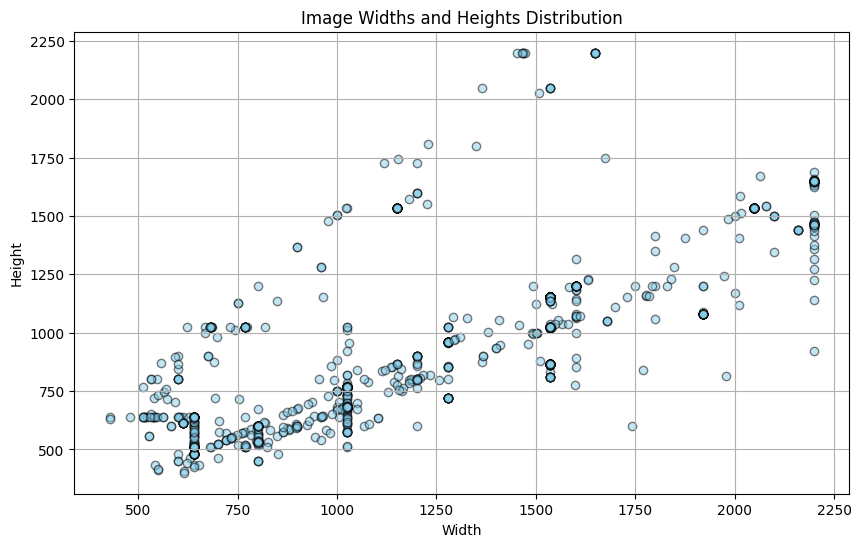

In [114]:
heights = []
widths = []

for dataset, dataset_name in datasets:
    print(len(dataset))
    for data in dataset:
        img = cv2.imread(data["image"])[..., ::-1]
        
        h, w = img.shape[:2]

        heights.append(h)
        widths.append(w)
        
# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Widths and Heights Distribution')
plt.grid(True)
plt.show()


In [134]:
plt.close()